In [1]:
import random
import pandas as pd
import numpy as np
from numpy import array
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import graphviz

import sklearn
print(sklearn.__version__)

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

1.1.1


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
#from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
#from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
#LeakyReLU = LeakyReLU(alpha=0.1)
from tensorflow.keras.models import save_model

In [3]:
#from google.colab import drive
#drive.mount("/content/gdrive")
#!pip3 install graphviz
#!pip3 install bayesian-optimization
#!pip3 install h5py

In [4]:
#print(bits_64qam)
#symbol_length = [500] # Packet sequence length
NB_CLASSES = 7 # number of outputs = number of classes
VERBOSE = 1
BATCH_SIZE = 10
NB_EPOCH = 100
target_names =  ['Ob(BPSK)', 'Ob2(QPSK)', 'Ob2(16-QAM)', 'Ob2(64-QAM)', 'Ob4(QPSK)', 'Ob4(16-QAM)', 'Ob4(64-QAM)']
file_short = "D:/BMO/Main/savedModels/7input_model_short.h5"
file_mid1 = "D:/BMO/Main/savedModels/7input_model_mid1.h5"
file_mid2 = "D:/BMO/Main/savedModels/7input_model_mid2.h5"
file_long = "D:/BMO/Main/savedModels/7input_model_long.h5"
file_best = "D:/BMO/Main/savedModels/7input_model_best.h5"

In [5]:
#symbol_length =   [36, 100, 200, 250, 300, 350, 400, 450, 500]
symbol_length =   [500]

In [6]:
%%time

print(".........Loading MO (2-state) dataset..........")

# sep separates each column and header = none means it is going to read from row 1
re2psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/BPSK-2/real.xls',sep='\t', header=None) 
im2psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/BPSK-2/im.xls',sep='\t', header=None)

# sep separates each column and header = none means it is going to read from row 1
re4psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/QPSK-2/real.xls',sep='\t', header=None) 
im4psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/QPSK-2/im.xls',sep='\t', header=None)

# sep separates each column and header = none means it is going to read from row 1
re16qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/16-QAM-2/real.xls',sep='\t', header=None) 
im16qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/16-QAM-2/im.xls',sep='\t', header=None)

# sep separates each column and header = none means it is going to read from row 1
re64qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/64-QAM-2/real.xls',sep='\t', header=None) 
im64qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/64-QAM-2/im.xls',sep='\t', header=None)

#merge two dataframes into one
df2psk_2st = re2psk_2st + im2psk_2st * 1j
df2psk_2st.drop(df2psk_2st.iloc[:, 500:], inplace = True, axis = 1)
df2psk_2st['Mod'] = 0 # 0 = BPSK 2-state
#merge two dataframes into one
df4psk_2st = re4psk_2st + im4psk_2st * 1j
df4psk_2st.drop(df4psk_2st.iloc[:, 500:], inplace = True, axis = 1)
df4psk_2st['Mod'] = 1 # 1 = QPSK 2-state
#merge two dataframes into one
df16qam_2st = re16qam_2st + im16qam_2st * 1j
df16qam_2st.drop(df16qam_2st.iloc[:, 500:], inplace = True, axis = 1)
df16qam_2st['Mod'] = 2 # 2 = 16-QAM 2-state
#merge two dataframes into one
df64qam_2st = re64qam_2st + im64qam_2st * 1j
df64qam_2st.drop(df64qam_2st.iloc[:, 500:], inplace = True, axis = 1)
df64qam_2st['Mod'] = 3 # 3 = 64-QAM 2-state


# combine all
df_2st = df2psk_2st.append(df4psk_2st)
df_2st = df_2st.append(df16qam_2st)
df_2st = df_2st.append(df64qam_2st)

df_2st = df_2st.sample(frac = 1)
print('df_2st Shape = ', df_2st.shape)

.........Loading MO (2-state) dataset..........
df_2st Shape =  (28000, 501)
CPU times: total: 46.8 s
Wall time: 1min 7s


In [7]:
%%time

print(".........Loading MO (4-state) dataset..........")

# sep separates each column and header = none means it is going to read from row 1
re2psk_4st = pd.read_csv('D:/BMO/Main/bigDataset/BPSK-4/real.xls',sep='\t', header=None) 
im2psk_4st = pd.read_csv('D:/BMO/Main/bigDataset/BPSK-4/im.xls',sep='\t', header=None)

# sep separates each column and header = none means it is going to read from row 1
re4psk_4st = pd.read_csv('D:/BMO/Main/bigDataset/QPSK-4/real.xls',sep='\t', header=None) 
im4psk_4st = pd.read_csv('D:/BMO/Main/bigDataset/QPSK-4/im.xls',sep='\t', header=None)

# sep separates each column and header = none means it is going to read from row 1
re16qam_4st = pd.read_csv('D:/BMO/Main/bigDataset/16-QAM-4/real.xls',sep='\t', header=None) 
im16qam_4st = pd.read_csv('D:/BMO/Main/bigDataset/16-QAM-4/im.xls',sep='\t', header=None)

# sep separates each column and header = none means it is going to read from row 1
re64qam_4st = pd.read_csv('D:/BMO/Main/bigDataset/64-QAM-4/real.xls',sep='\t', header=None) 
im64qam_4st = pd.read_csv('D:/BMO/Main/bigDataset/64-QAM-4/im.xls',sep='\t', header=None)

#merge two dataframes into one
df2psk_4st = re2psk_4st + im2psk_4st * 1j
df2psk_4st.drop(df2psk_4st.iloc[:, 500:], inplace = True, axis = 1)
df2psk_4st['Mod'] = 0 # 0 = BPSK 2-state
#merge two dataframes into one
df4psk_4st = re4psk_4st + im4psk_4st * 1j
df4psk_4st.drop(df4psk_4st.iloc[:, 500:], inplace = True, axis = 1)
df4psk_4st['Mod'] = 4 # 1 = QPSK 2-state
#merge two dataframes into one
df16qam_4st = re16qam_4st + im16qam_4st * 1j
df16qam_4st.drop(df16qam_4st.iloc[:, 500:], inplace = True, axis = 1)
df16qam_4st['Mod'] = 5 # 2 = 16-QAM 2-state
#merge two dataframes into one
df64qam_4st = re64qam_4st + im64qam_4st * 1j
df64qam_4st.drop(df64qam_4st.iloc[:, 500:], inplace = True, axis = 1)
df64qam_4st['Mod'] = 6 # 3 = 64-QAM 2-state

# combine all
df_4st = df2psk_4st.append(df4psk_4st)
df_4st = df_4st.append(df16qam_4st)
df_4st = df_4st.append(df64qam_4st)

df_4st = df_4st.sample(frac = 1)
print('df_4st Shape = ', df_4st.shape)

.........Loading MO (4-state) dataset..........
df_4st Shape =  (28000, 501)
CPU times: total: 23.2 s
Wall time: 34.3 s


In [8]:
print("..........Combining all data..........")

# combine all
df = df_2st.append(df_4st)
df_all = df.sample(frac = 1)
print('df_all Shape = ', df_all.shape)
print("..........Shuffling done..........")

# reducing samples to tune only
#df_all = df_all.iloc[:16384]
print('df_all Size = ', df_all.size)
print('Dimension = ', df_all.ndim)
print('Combined Shape = ', df_all.shape)

..........Combining all data..........
df_all Shape =  (56000, 501)
..........Shuffling done..........
df_all Size =  28056000
Dimension =  2
Combined Shape =  (56000, 501)


In [9]:
%%time

f1_bp2 = []
f1_qp2 = []
f1_162 = []
f1_642 = []
f1_bp4 = []
f1_qp4 = []
f1_164 = []
f1_644 = []

ac_bp2 = []
ac_qp2 = []
ac_162 = []
ac_642 = []
ac_bp4 = []
ac_qp4 = []
ac_164 = []
ac_644 = []

f1_bp = []
f1_qp = []
f1_16 = []
f1_64 = []
re_bp = []
re_qp = []
re_16 = []
re_64 = []
pr_bp = []
pr_qp = []
pr_16 = []
pr_64 = []
ac_bp = []
ac_qp = []
ac_16 = []
ac_64 = []

f1mc_bp = []
f1mc_qp = []
f1mc_16 = []
f1mc_64 = []
remc_bp = []
remc_qp = []
remc_16 = []
remc_64 = []
prmc_bp = []
prmc_qp = []
prmc_16 = []
prmc_64 = []
acmc_bp = []
acmc_qp = []
acmc_16 = []
acmc_64 = []

accuracy = []
f1score = []
loss = []
precision = []
false_pos = []
true_pos = []
recall = []

for LENGTH in symbol_length:
    
    # Separating X and y
    y = df_all['Mod'] # 1D targer vector
    X = df_all.drop(columns='Mod')

    INPUT_SHAPE = (LENGTH,1)

    X.drop(X.iloc[:, LENGTH:2048], inplace = True, axis = 1)

    X = np.expand_dims(X, -1)

    # Split into training/testing sets with 20% split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1) 

    print("..........Training set..........")
    print(X_train.shape)
    print(y_train.shape)
    print("..........Validation set..........")
    print(X_val.shape)
    print(y_val.shape)
    print("..........Testing set..........")
    print(X_test.shape)
    print(y_test.shape)

    # Convert class vectors to categorical classes matrices
    y_train = np_utils.to_categorical(y_train, NB_CLASSES)
    y_test = np_utils.to_categorical(y_test, NB_CLASSES)
    y_val = np_utils.to_categorical(y_val, NB_CLASSES)

    from keras.constraints import maxnorm

    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        filter_num = ['None',32,64,128,256]
        kernel_size = ['None',8,8,8,8]
        conv_stride_size = ['None',1,1,1,1]
        pool_stride_size = ['None',4,4,4,4]
        pool_size = ['None',8,8,8,8]
        batch_size = 10
        dropout_rate =0.0
        # Feature extraction
        model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=INPUT_SHAPE,
                             strides=conv_stride_size[1], padding='same',
                             name='convolution1'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation1'))
        model.add(MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                                   padding='same', name='pool1'))
        model.add(Dropout(dropout_rate, name='dropout1'))

        # Output layer
        model.add(Flatten(name='flatten1'))
        model.add(Dense(NB_CLASSES, kernel_initializer=glorot_uniform(seed=0), name='dense1'))
        model.add(Activation('softmax', name="softmax"))

        # Compile model
        model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.6), metrics=["accuracy"])

        return model

    model = create_model()
    # simple early stopping
    es_lr = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc_lr = ModelCheckpoint(file_best, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    # fit model
    model_history = model.fit(X_train, y_train, epochs=NB_EPOCH, verbose=VERBOSE, 
                                validation_data=(X_val, y_val), callbacks=[es_lr, mc_lr])
    
    
    # Start evaluating model with testing data
    score_test = model.evaluate(X_test, y_test, verbose=VERBOSE)
    y_pred = model.predict(X_test)
    y_pred1=np.argmax(y_pred, axis=1)
    y_test1=np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test1, y_pred1)
    
    acc = score_test[1]
    accuracy.append(acc)
    
    ls = score_test[0]
    loss.append(ls)
    
    f1s = f1_score(y_test1, y_pred1, average=None)
    print(f1s)
    #f1score.append((f1s[0]+f1s[1])/2)
    for index, val in np.ndenumerate(f1s):
            if (index[0]==0): 
                f1b = val
            if (index[0]==1): 
                f1q2 = val
            if (index[0]==2):
                f1162 = val
            if (index[0]==3): 
                f1642 = val
            if (index[0]==4): 
                f1q4 = val
            if (index[0]==5): 
                f1164 = val
            if (index[0]==6): 
                f1644 = val
       

    f1_bp.append(f1b)
    f1_qp2.append(f1q2)
    f1_162.append(f1162)
    f1_642.append(f1642)

    f1_qp4.append(f1q4)
    f1_164.append(f1164)
    f1_644.append(f1644)
    
    
    cm = confusion_matrix(y_test1, y_pred1)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print('Confusion Matrix when Symbol Length ', LENGTH)
    #f = sns.heatmap(cm, cmap='Greens', annot=True, square=True, yticklabels = True)
    #cmratio = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #plt.rcParams["figure.figsize"] = (7.5,7.5)
    #plt.rcParams.update({'font.size': 14})
    #f = sns.heatmap(cm, cmap='Purples', annot=True, square=True, yticklabels = True)
    
    accuracys = cm.diagonal()
    #acc = accuracy.reshape(-1,1)
    print(accuracys)
    for index, val in np.ndenumerate(accuracys):
            if (index[0]==0): 
                a1b = val
            if (index[0]==1): 
                a1q2 = val
            if (index[0]==2):
                a1162 = val
            if (index[0]==3): 
                a1642 = val
            if (index[0]==4): 
                a1q4 = val
            if (index[0]==5):
                a1164 = val
            if (index[0]==6): 
                a1644 = val
    ac_bp.append(a1b)
    ac_qp2.append(a1q2)
    ac_162.append(a1162)
    ac_642.append(a1642)
    ac_qp4.append(a1q4)
    ac_164.append(a1164)
    ac_644.append(a1644)
    
    

..........Training set..........
(40320, 500, 1)
(40320,)
..........Validation set..........
(4480, 500, 1)
(4480,)
..........Testing set..........
(11200, 500, 1)
(11200,)
Epoch 1/100
1258/1260 [============================>.] - ETA: 0s - loss: 1.4926 - accuracy: 0.5260
Epoch 1: val_accuracy improved from -inf to 0.73973, saving model to D:/BMO/Main/savedModels\7input_model_best.h5
1260/1260 [==============================] - 26s 20ms/step - loss: 1.4920 - accuracy: 0.5261 - val_loss: 0.7250 - val_accuracy: 0.7397
Epoch 2/100
1258/1260 [============================>.] - ETA: 0s - loss: 0.5216 - accuracy: 0.8198
Epoch 2: val_accuracy improved from 0.73973 to 0.86004, saving model to D:/BMO/Main/savedModels\7input_model_best.h5
1260/1260 [==============================] - 23s 18ms/step - loss: 0.5215 - accuracy: 0.8198 - val_loss: 0.4099 - val_accuracy: 0.8600
Epoch 3/100
1260/1260 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.8991
Epoch 3: val_accuracy improve

1260/1260 [==============================] - 15s 12ms/step - loss: 0.0108 - accuracy: 0.9989 - val_loss: 0.0983 - val_accuracy: 0.9696
Epoch 27/100
1257/1260 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9991
Epoch 27: val_accuracy improved from 0.97188 to 0.97232, saving model to D:/BMO/Main/savedModels\7input_model_best.h5
1260/1260 [==============================] - 15s 12ms/step - loss: 0.0100 - accuracy: 0.9991 - val_loss: 0.0957 - val_accuracy: 0.9723
Epoch 28/100
1257/1260 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9989
Epoch 28: val_accuracy improved from 0.97232 to 0.97254, saving model to D:/BMO/Main/savedModels\7input_model_best.h5
1260/1260 [==============================] - 15s 12ms/step - loss: 0.0096 - accuracy: 0.9989 - val_loss: 0.0928 - val_accuracy: 0.9725
Epoch 29/100
1260/1260 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9996
Epoch 29: val_accuracy improved from 0.97254 to 0.97522, sa

In [10]:
print("Symbol series length = ", LENGTH)

y_pred1=np.argmax(y_pred, axis=1)
y_test1=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test1, y_pred1)
print(cm)
#f = sns.heatmap(cm, cmap='Purples', annot=True, square=True, yticklabels = True)

Symbol series length =  500
[[2589    7    0    4   94   17   90]
 [  12 1333    1    0    1    0    0]
 [   0    0 1458    0    0    0    0]
 [   0    0    0 1364    0    0    0]
 [  89    0    0    1 1354    2    3]
 [   0    0    0    0    0 1366    0]
 [   0    0    0    0    0    0 1415]]


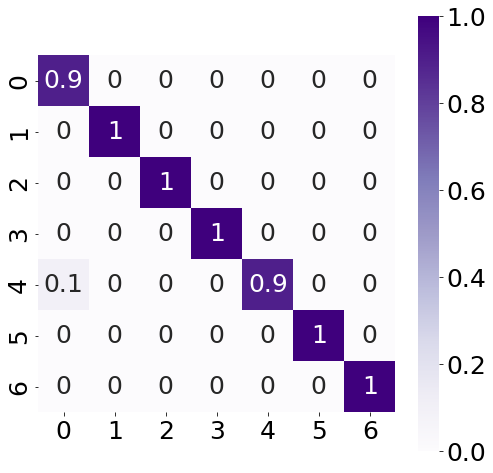

In [11]:
cmratio_short = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmratio_short= np.around(cmratio_short.astype('float') / cmratio_short.sum(axis=1)[:, np.newaxis], decimals=1)
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams.update({'font.size': 25})
f_short = sns.heatmap(cmratio_short, cmap='Purples', annot=True, square=True, yticklabels = True)
plt.show()